In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import random
from PIL import Image, ImageOps, ImageFilter
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from torch.utils import data
import time
import copy
from tqdm import tqdm

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 24 19:08:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


Downloading the pacakges of U-net

In [5]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-p9l95xd9
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-p9l95xd9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


import dataset from mit

In [ ]:
#!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
#!unzip ADEChallengeData2016.zip && rm ADEChallengeData2016.zip
#!mv /content/ADEChallengeData2016 /content/drive/MyDrive/6.869

In [ ]:
#!unzip ADEChallengeData2016.zip
#!mv /content/ADEChallengeData2016 /content/drive/MyDrive/6.869

In [6]:
TARGET_GOOGLE_DRIVE_DIR = '/content/drive/MyDrive/6.869/ADEChallengeData2016'

Show some images

#Take a Look on Dataset

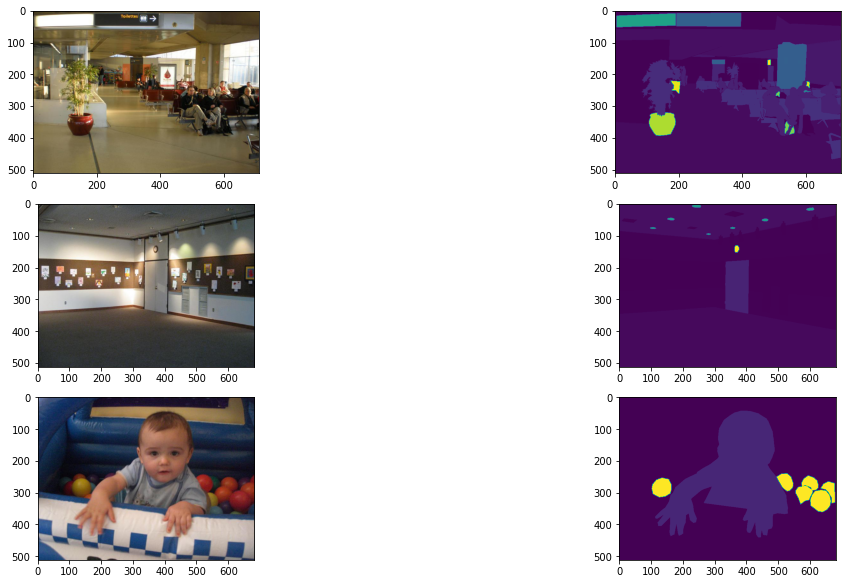

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)
for i,image_name in enumerate(image_name_list):
  original_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  label_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR, "annotations", "training", f"{image_name}.png")
  original_img = Image.open(original_image).convert('RGB')
  mask_img = Image.open(label_image)

  axs[i,0].imshow(original_img)
  axs[i,0].grid(False)

  label_image = np.asarray(mask_img)
  axs[i,1].imshow(label_image)
  axs[i,1].grid(False)


In [7]:
class SegmentationDataset(object):
    """Segmentation Base Dataset"""

    def __init__(self, root, split, mode, transform, base_size=520, crop_size=480):
        super(SegmentationDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.split = split
        self.mode = mode if mode is not None else split
        self.base_size = base_size
        self.crop_size = crop_size

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = outsize
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize) / 2.))
        y1 = int(round((h - outsize) / 2.))
        img = img.crop((x1, y1, x1 + outsize, y1 + outsize))
        mask = mask.crop((x1, y1, x1 + outsize, y1 + outsize))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < crop_size:
            padh = crop_size - oh if oh < crop_size else 0
            padw = crop_size - ow if ow < crop_size else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=0)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size)
        y1 = random.randint(0, h - crop_size)
        img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        mask = mask.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        # gaussian blur as in PSP
        if random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.random()))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        return np.array(mask).astype('int32')

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0

In [8]:

class ADE20KSegmentation(SegmentationDataset):
    """ADE20K Semantic Segmentation Dataset.
    Parameters
    ----------
    root : string
        Path to ADE20K folder. Default is './datasets/ade'
    split: string
        'train', 'val' or 'test'
    transform : callable, optional
        A function that transforms the image
    Examples
    --------
    >>> from torchvision import transforms
    >>> import torch.utils.data as data
    >>> # Transforms for Normalization
    >>> input_transform = transforms.Compose([
    >>>     transforms.ToTensor(),
    >>>     transforms.Normalize((.485, .456, .406), (.229, .224, .225)),
    >>> ])
    >>> # Create Dataset
    >>> trainset = ADE20KSegmentation(split='train', transform=input_transform)
    >>> # Create Training Loader
    >>> train_data = data.DataLoader(
    >>>     trainset, 4, shuffle=True,
    >>>     num_workers=4)
    """
    BASE_DIR = 'ADEChallengeData2016'
    NUM_CLASS = 150

    def __init__(self, root='/content/drive/MyDrive/6.869', split='train', mode=None, transform=None, **kwargs):
        super(ADE20KSegmentation, self).__init__(root, split, mode, transform, **kwargs)
        root = os.path.join(root, self.BASE_DIR)
        self.images, self.masks = _get_ade20k_pairs(root, split)
        assert (len(self.images) == len(self.masks))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")
        print('Found {} images in the folder {}'.format(len(self.images), root))

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            img = self._img_transform(img)
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.masks[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and to Tensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask, os.path.basename(self.images[index])

    def _mask_transform(self, mask):
        return torch.LongTensor(np.array(mask).astype('int32') - 1)

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 1

    @property
    def classes(self):
        """Category names."""
        return ("wall", "building, edifice", "sky", "floor, flooring", "tree",
                "ceiling", "road, route", "bed", "windowpane, window", "grass",
                "cabinet", "sidewalk, pavement",
                "person, individual, someone, somebody, mortal, soul",
                "earth, ground", "door, double door", "table", "mountain, mount",
                "plant, flora, plant life", "curtain, drape, drapery, mantle, pall",
                "chair", "car, auto, automobile, machine, motorcar",
                "water", "painting, picture", "sofa, couch, lounge", "shelf",
                "house", "sea", "mirror", "rug, carpet, carpeting", "field", "armchair",
                "seat", "fence, fencing", "desk", "rock, stone", "wardrobe, closet, press",
                "lamp", "bathtub, bathing tub, bath, tub", "railing, rail", "cushion",
                "base, pedestal, stand", "box", "column, pillar", "signboard, sign",
                "chest of drawers, chest, bureau, dresser", "counter", "sand", "sink",
                "skyscraper", "fireplace, hearth, open fireplace", "refrigerator, icebox",
                "grandstand, covered stand", "path", "stairs, steps", "runway",
                "case, display case, showcase, vitrine",
                "pool table, billiard table, snooker table", "pillow",
                "screen door, screen", "stairway, staircase", "river", "bridge, span",
                "bookcase", "blind, screen", "coffee table, cocktail table",
                "toilet, can, commode, crapper, pot, potty, stool, throne",
                "flower", "book", "hill", "bench", "countertop",
                "stove, kitchen stove, range, kitchen range, cooking stove",
                "palm, palm tree", "kitchen island",
                "computer, computing machine, computing device, data processor, "
                "electronic computer, information processing system",
                "swivel chair", "boat", "bar", "arcade machine",
                "hovel, hut, hutch, shack, shanty",
                "bus, autobus, coach, charabanc, double-decker, jitney, motorbus, "
                "motorcoach, omnibus, passenger vehicle",
                "towel", "light, light source", "truck, motortruck", "tower",
                "chandelier, pendant, pendent", "awning, sunshade, sunblind",
                "streetlight, street lamp", "booth, cubicle, stall, kiosk",
                "television receiver, television, television set, tv, tv set, idiot "
                "box, boob tube, telly, goggle box",
                "airplane, aeroplane, plane", "dirt track",
                "apparel, wearing apparel, dress, clothes",
                "pole", "land, ground, soil",
                "bannister, banister, balustrade, balusters, handrail",
                "escalator, moving staircase, moving stairway",
                "ottoman, pouf, pouffe, puff, hassock",
                "bottle", "buffet, counter, sideboard",
                "poster, posting, placard, notice, bill, card",
                "stage", "van", "ship", "fountain",
                "conveyer belt, conveyor belt, conveyer, conveyor, transporter",
                "canopy", "washer, automatic washer, washing machine",
                "plaything, toy", "swimming pool, swimming bath, natatorium",
                "stool", "barrel, cask", "basket, handbasket", "waterfall, falls",
                "tent, collapsible shelter", "bag", "minibike, motorbike", "cradle",
                "oven", "ball", "food, solid food", "step, stair", "tank, storage tank",
                "trade name, brand name, brand, marque", "microwave, microwave oven",
                "pot, flowerpot", "animal, animate being, beast, brute, creature, fauna",
                "bicycle, bike, wheel, cycle", "lake",
                "dishwasher, dish washer, dishwashing machine",
                "screen, silver screen, projection screen",
                "blanket, cover", "sculpture", "hood, exhaust hood", "sconce", "vase",
                "traffic light, traffic signal, stoplight", "tray",
                "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, "
                "dustbin, trash barrel, trash bin",
                "fan", "pier, wharf, wharfage, dock", "crt screen",
                "plate", "monitor, monitoring device", "bulletin board, notice board",
                "shower", "radiator", "glass, drinking glass", "clock", "flag")


def _get_ade20k_pairs(folder, mode='train'):
    img_paths = []
    mask_paths = []
    if mode == 'train':
        img_folder = os.path.join(folder, 'images/training')
        mask_folder = os.path.join(folder, 'annotations/training')
    else:
        img_folder = os.path.join(folder, 'images/validation')
        mask_folder = os.path.join(folder, 'annotations/validation')
    for filename in os.listdir(img_folder):
        basename, _ = os.path.splitext(filename)
        if filename.endswith(".jpg"):
            imgpath = os.path.join(img_folder, filename)
            maskname = basename + '.png'
            maskpath = os.path.join(mask_folder, maskname)
            if os.path.isfile(maskpath):
                img_paths.append(imgpath)
                mask_paths.append(maskpath)
            else:
                print('cannot find the mask:', maskpath)

    return img_paths, mask_paths


if __name__ == '__main__':
    train_dataset = ADE20KSegmentation()

Found 20210 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016


#Fully Convolutional Networks

In [9]:
FCN_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
FCN_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

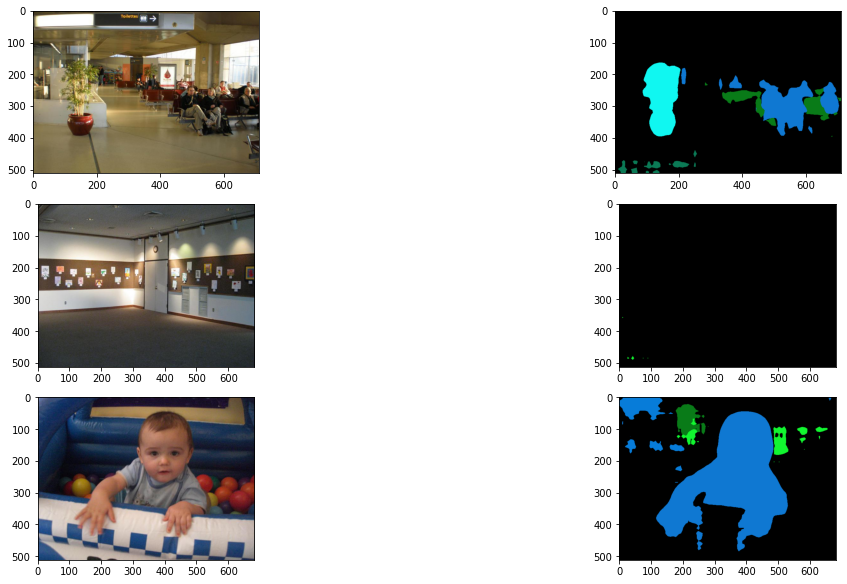

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  #add batch dimension
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = FCN_model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

In [10]:
new_FCN_model = FCN_model
new_FCN_model.classifier[4] = nn.Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
print(new_FCN_model.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
)


In [11]:
new_FCN_model.aux_classifier[4] = nn.Conv2d(256, 150, kernel_size=(1, 1), stride=(1, 1))
print(new_FCN_model.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 150, kernel_size=(1, 1), stride=(1, 1))
)


<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


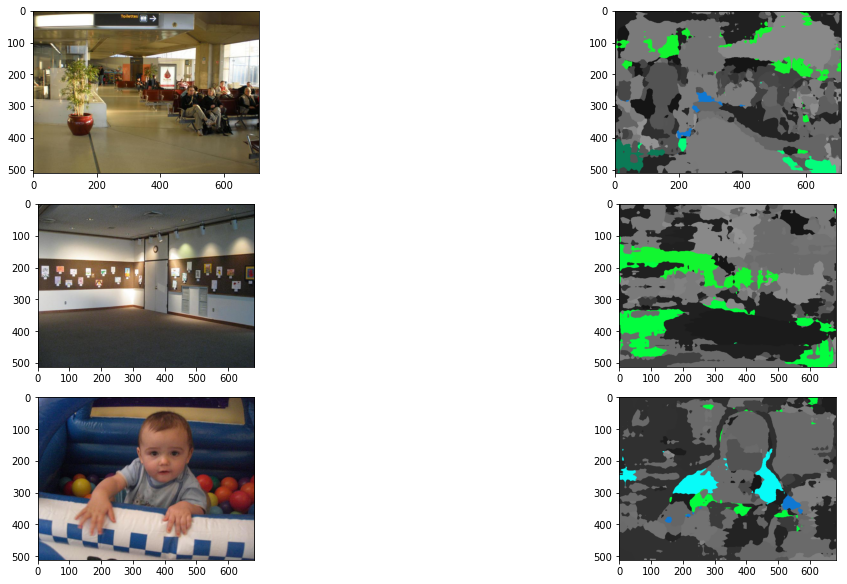

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
new_FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = new_FCN_model(input_batch)
    print(type(output))
    print(output['out'].shape)
    output = output['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

In [13]:
#retrain the model
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.CenterCrop(480)
])


In [25]:
trainset = ADE20KSegmentation(split='train', transform=image_transform)
validationset = ADE20KSegmentation(split='val', transform=image_transform)
testset = ADE20KSegmentation(split='test', transform=image_transform)

Found 20210 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016
Found 2000 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016
Found 2000 images in the folder /content/drive/MyDrive/6.869/ADEChallengeData2016


In [ ]:
# Create Training Loader
train_dataloader = data.DataLoader(
    trainset, batch_size = 8, shuffle=True,
    num_workers=2)
validation_dataloader = data.DataLoader(
    validationset,batch_size = 8, shuffle=True,
    num_workers=2
)
test_dataloader = data.DataLoader(
    testset, batch_size = 8, shuffle=True,
    num_workers = 2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([8, 3, 480, 480])
Labels batch shape: torch.Size([8, 480, 480])


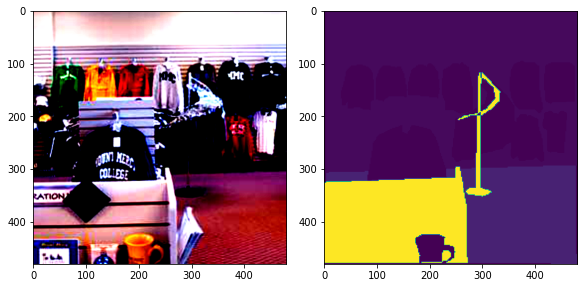

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
train_data= next(iter(train_dataloader))
print(f"Feature batch shape: {train_data[0].size()}")
print(f"Labels batch shape: {train_data[1].size()}")
train_image = torch.tensor(train_data[0][0, :, :, :]).permute(1,2,0)
axs[0].imshow(train_image)
semantic_image = train_data[1][0,:,:]
axs[1].imshow(semantic_image)

In [32]:
def visualize_performance_on_sample_image():
  image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  new_FCN_model.to('cuda')
  fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

  for i,image_name in enumerate(image_name_list):
    input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
    input_image = Image.open(input_image).convert('RGB')

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)


    input_batch = input_batch.to('cuda')

    with torch.no_grad():
      output = new_FCN_model(input_batch)
      print(type(output))
      print(output['out'].shape)
      output = output['out'][0]
    output_predictions = output.argmax(0)

    #palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    #colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    #colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    #r.putpalette(colors)
    axs[i,0].imshow(input_image)
    axs[i,1].imshow(r)

In [15]:
def one_hot_encoding(label,label_values = range(150)):
  semantic_map = []
  for i in label_values:
    class_map = (label == i)*1
    semantic_map.append(class_map)
  mask_coded = np.stack(semantic_map,axis = -1)
  mask_coded = torch.tensor(mask_coded)
  mask_coded = mask_coded.permute(0,3,1,2)
  return mask_coded

In [17]:
optimizer = torch.optim.SGD(new_FCN_model.parameters(), lr=0.001, momentum=0.9)
loss_f = nn.CrossEntropyLoss()
def train_model(model,train_dataloader,validation_dataloader,optimizer,loss_f,num_epochs):
  since = time.time()
  train_loss = []
  running_loss = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    for i in tqdm(range(1000)):
    #for i,input_pairs in enumerate(train_dataloader):
      input_pairs = next(iter(train_dataloader))
      train_data = input_pairs[0]
      semantic_data = input_pairs[1]
      train_data = train_data.to(device)
      semantic_data = one_hot_encoding(semantic_data)
      semantic_data = semantic_data.to(device)
      optimizer.zero_grad()
      output = model(train_data)['out']
      loss = loss_f(output,semantic_data.float())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss/len(train_dataloader.dataset)
    train_loss.append(epoch_loss)
    return model,train_loss


In [ ]:
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 2000/2000 [3:17:41<00:00,  5.93s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

After training 2000 images

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


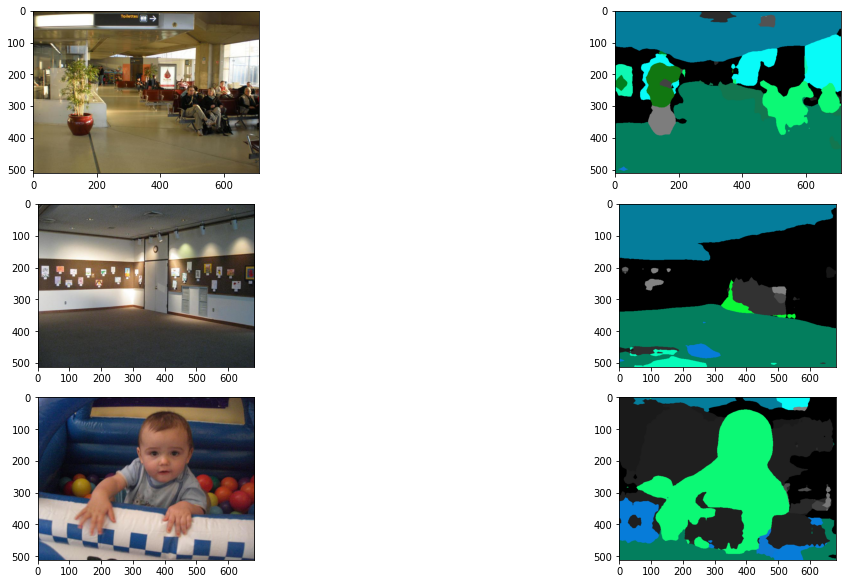

In [ ]:
image_name_list = ["ADE_train_00000002","ADE_train_00000003","ADE_train_00000005"]
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
new_FCN_model.to('cuda')
fig, axs = plt.subplots(len(image_name_list), 2, figsize=(16, 8), constrained_layout=True)

for i,image_name in enumerate(image_name_list):
  input_image = os.path.join(TARGET_GOOGLE_DRIVE_DIR,"images","training",f"{image_name}.jpg")
  input_image = Image.open(input_image).convert('RGB')

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)


  input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = new_FCN_model(input_batch)
    print(type(output))
    print(output['out'].shape)
    output = output['out'][0]
  output_predictions = output.argmax(0)

  palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
  colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
  colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
  r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  r.putpalette(colors)
  axs[i,0].imshow(input_image)
  axs[i,1].imshow(r)

save current trained model

In [ ]:
model_name = "new_FCN"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

train another epoch

In [16]:
model_name = "new_FCN"
path = '/content/drive/MyDrive/6.869/{model_name}'
new_FCN_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [18]:
train_dataloader = data.DataLoader(
    trainset, batch_size = 4, shuffle=True,
    num_workers=2)
validation_dataloader = data.DataLoader(
    validationset,batch_size = 4, shuffle=True,
    num_workers=2
)

In [19]:
new_FCN_model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [20]:
#second time
#train another epoch
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 1000/1000 [1:18:10<00:00,  4.69s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


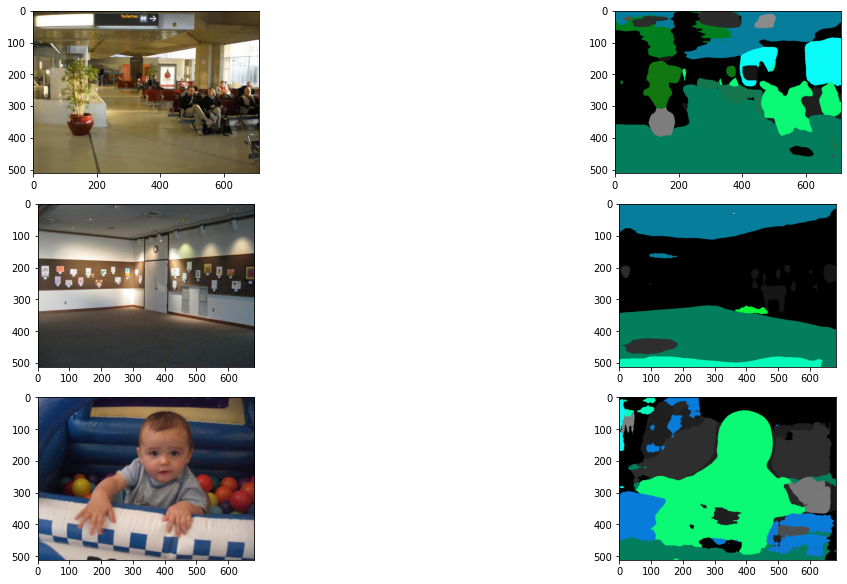

In [24]:
visualize_performance_on_sample_image()

In [26]:
model_name = "new_FCN2"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

detection of wall, floor is getting better but human detection performance seems decay

In [27]:
#third time
train_model(new_FCN_model,train_dataloader,validation_dataloader,optimizer,loss_f,1)

Epoch 1/1
----------


100%|██████████| 1000/1000 [1:08:08<00:00,  4.09s/it]


(FCN(
   (backbone): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downs

<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 711])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])
<class 'collections.OrderedDict'>
torch.Size([1, 150, 512, 683])


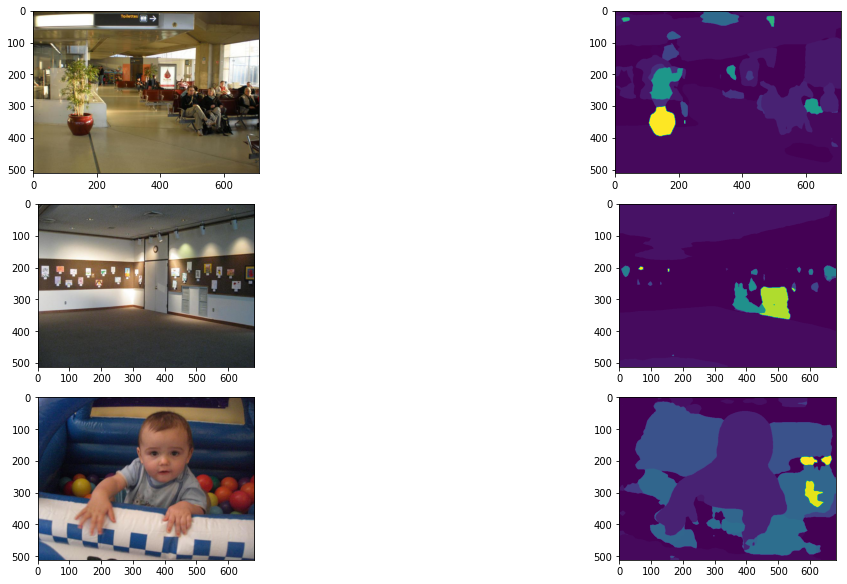

In [33]:
visualize_performance_on_sample_image()

In [34]:
model_name = "new_FCN3"
path = '/content/drive/MyDrive/6.869/{model_name}'
torch.save(new_FCN_model.state_dict(), path)

#U-NET

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


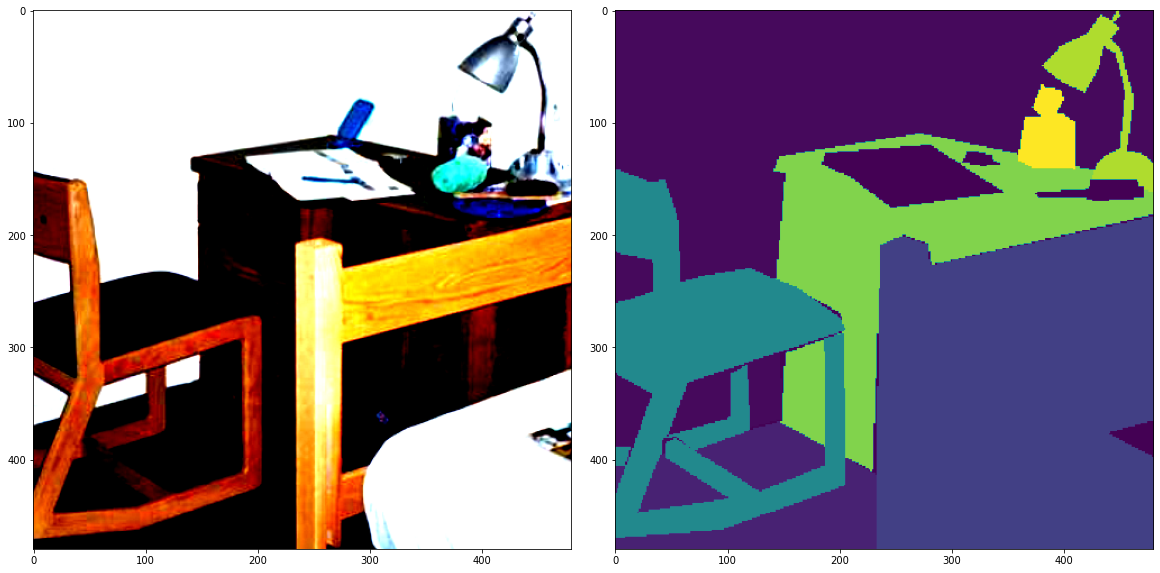

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

orig_img = torch.tensor(pairs[0][0, :, :, :]).permute(1,2,0)
axs[0].imshow(orig_img)
axs[0].grid(False)

label_img = pairs[1][0, :, :]
axs[1].imshow(label_img)
axs[1].grid(False)